In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
DICE = np.arange(1, 7)
CHEATED_P = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.5])

CNT = 10_000
P_HTC = 0.04
P_CTH = 0.05

STATES = {0: 'cheated', 1: 'honest'}
INIT_P = {0: 0, 1: 1}

In [3]:
def honest_throw():
    return np.random.choice(DICE)

def cheated_throw():
    return np.random.choice(DICE, p=CHEATED_P)

In [4]:
def gen_throws():
    s = 1
    results = []
    states = []
    for _ in range(CNT):
        if s == 1:
            if np.random.ranf() < P_HTC:
                s = 0
        else:
            if np.random.ranf() < P_CTH:
                s = 1
        states.append(s)
        r = honest_throw() if s == 1 else cheated_throw()
        results.append(r)
    return np.array(results), np.array(states)

In [5]:
PLT_CSCHEME = {1: 'g', 0: 'r'}

<BarContainer object of 10000 artists>

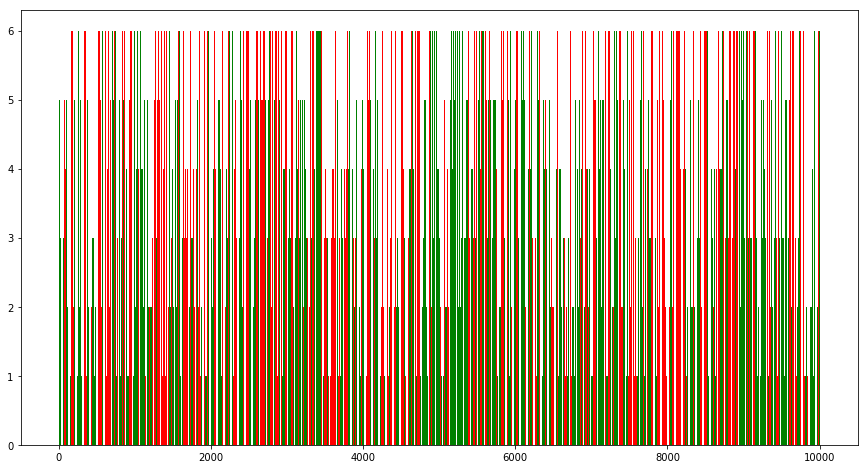

In [6]:
rs, ss = gen_throws()
_, ax = plt.subplots(1, 1, figsize=(15, 8))
cs = [PLT_CSCHEME[s] for s in ss]
ax.bar(np.arange(CNT), rs, color=cs)

In [7]:
def heuristic_predict(rs):
    """Inspect 6s ratio between every two 6s
    if above 1/3, decide on a cheated interval
    """
    RATIO = 1 / 3
    buf = []
    ss = []
    for i, r in enumerate(rs):
        buf.append(r)
        if r == 6 or i == len(rs) - 1:
            ratio = len([r for r in buf if r == 6]) / len(buf)
            s = 0 if ratio >= RATIO else 1
            ss.extend([s] * len(buf))
            buf = []
    return np.array(ss)

In [8]:
class Viterbi:
    def __init__(
        self,
        observation_space,
        state_space,
        initial_ps,
        transition_matrix,
        emission_matrix,
    ):
        self.observation_space = observation_space
        self.state_space = state_space
        self.initial_ps = initial_ps
        self.transition_matrix = transition_matrix
        self.emission_matrix = emission_matrix
    
    def get_states(self, observations):
        deltas = np.zeros((len(self.state_space), len(observations)))
        preds = np.zeros((len(self.state_space), len(observations)), dtype=np.int32)
        y0 = observations[0]
        deltas[:, 0] = np.log(self.initial_ps) + np.log(self.emission_matrix[:, y0])
        for i, y in enumerate(observations[1:]):
            for j in self.state_space:
                nexts = [
                    deltas[k, i - 1]
                    + np.log(self.transition_matrix[k, j])
                    + np.log(self.emission_matrix[j, y])
                    for k in self.state_space
                ]
                deltas[j, i] = np.max(nexts)
                preds[j, i] = np.argmax(nexts)
        Z = np.zeros(len(observations), dtype=np.int32)
        X = np.zeros(len(observations), dtype=np.int32)
        T = len(observations) - 1
        Z[T] = np.argmax(deltas[:, T])
        X[T] = self.state_space[Z[T]]
        for i in range(T, 2, -1):
            Z[i - 1] = preds[Z[i], i]
            X[i - 1] = self.state_space[Z[i - 1]]
        return X

In [9]:
v = Viterbi(
    DICE,
    np.array(list(STATES.keys())),
    np.array(list(INIT_P.keys())),
    np.array([
        [1 - P_HTC, P_HTC],
        [P_CTH, 1 - P_CTH],
    ]),
    np.array([
        CHEATED_P,
        np.ones(len(DICE)) / len(DICE),
    ])
)

/Users/sgorawski/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log


0.7723
0.8184


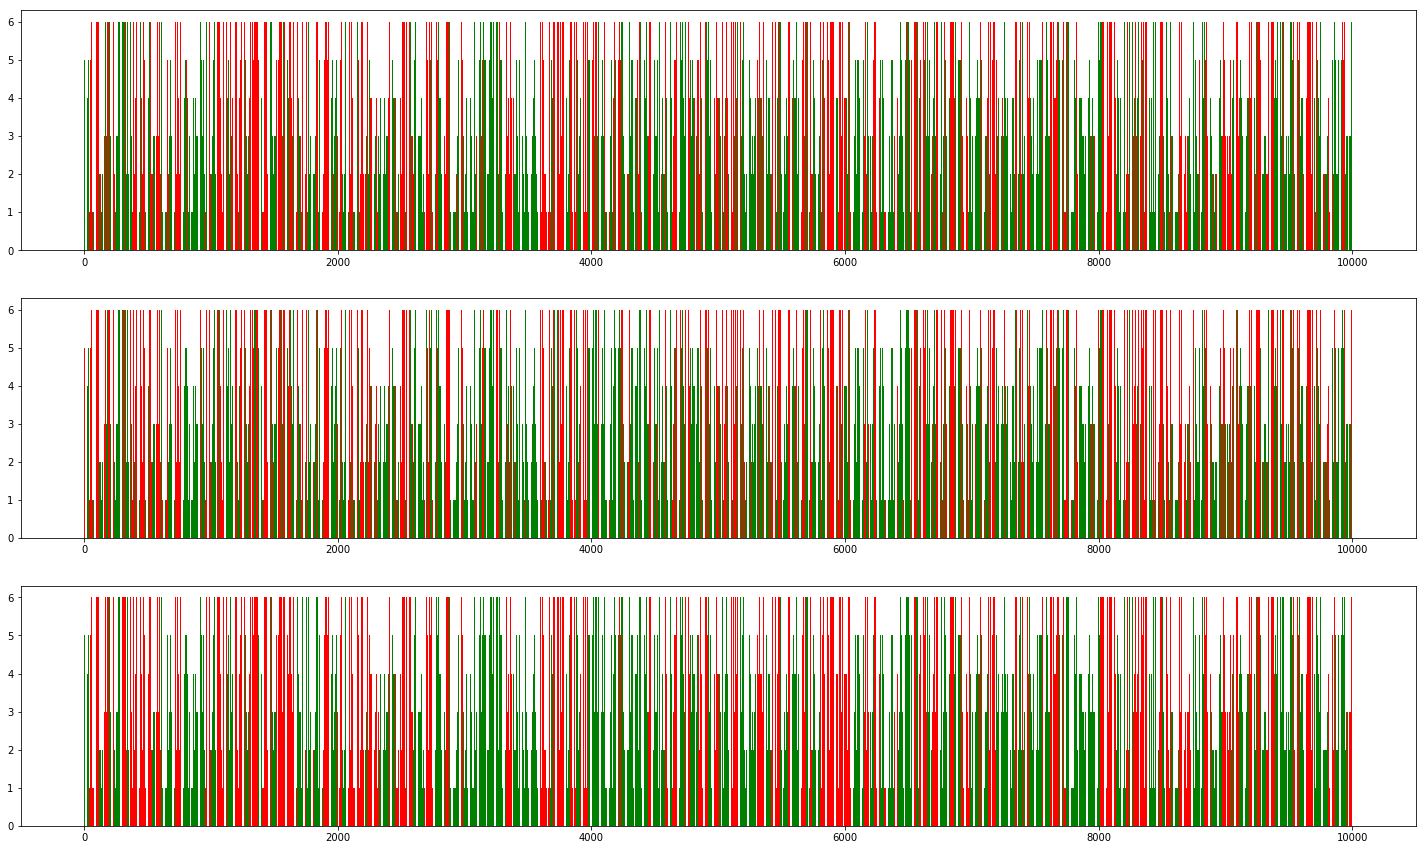

In [10]:
rs, ss = gen_throws()
hpred_ss = heuristic_predict(rs)
vpred_ss = v.get_states(rs - 1)
for pred_ss in hpred_ss, vpred_ss:
    print(np.sum(pred_ss == ss) / len(ss))

_, axes = plt.subplots(3, 1, figsize=(25, 15))
for ax, ss in zip(axes, (ss, hpred_ss, vpred_ss)):
    cs = [PLT_CSCHEME[s] for s in ss]
    ax.bar(np.arange(CNT), rs, color=cs)